In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
workDir = '/home/chantal/Chazy/Bulk/515_806/data/'
figDir = '/home/chantal/Chazy/Bulk/515_806/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'bulk-core-rare'


nprocs = 20

In [4]:
%%R
library(phyloseq)
library(tidyr)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

#### Read in sample metadata and OTU table

In [4]:
%%R

F = file.path(physeqDir, physeqBulk)
print(F)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS"),
                           physeq.Bulk)
physeq.Bulk.m = physeq.Bulk %>% sample_data


physeq.Bulk

[1] "/home/chantal/Chazy/data/phyloseq//bulk-core-rare"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19331 taxa and 175 samples ]
sample_data() Sample Data:       [ 175 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 19331 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 19331 tips and 19330 internal nodes ]


In [5]:
%%R
get_l2fc = function(physeq.obj, sparsity_threshold) {
    physeq.md = sample_data(physeq.obj)
   
    p = filter_taxa(physeq.obj, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
 
    dds = phyloseq_to_deseq2(p, ~ Till)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
        
    theta = 1
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
   
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "padj")])

   # d$padj = p.adjust(p, method = "BH")
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)


    d
}

In [6]:
%%R
# adding range of sparsity thresholds (all pairwise)

sdms = as.data.frame(seq(0.05,0.95,0.05))
colnames(sdms) = 'sparsity_threshold'
#cat('Number of pairwise combinations of variables:', sdms.P %>% nrow, '\n\n')
head(sdms) 

  sparsity_threshold
1               0.05
2               0.10
3               0.15
4               0.20
5               0.25
6               0.30


In [7]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(sdms, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq.Bulk))
df.l2fc

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:1

Source: local data frame [53,820 x 13]

   sparsity_threshold      OTU log2FoldChange     lfcSE         padj    Rank1
                (dbl)    (chr)          (dbl)     (dbl)        (dbl)   (fctr)
1                0.05 OTU.4940     -2.1008583 0.7271944 0.0146754283 Bacteria
2                0.05 OTU.4163     -0.5962939 0.7290722 0.5650960065 Bacteria
3                0.05 OTU.5493      0.4528195 0.7978311 0.7048193283 Bacteria
4                0.05 OTU.1739      0.4093300 0.4710808 0.5386344894 Bacteria
5                0.05 OTU.1813     -1.5067493 0.4472695 0.0036345646 Bacteria
6                0.05  OTU.778     -0.5508695 0.1382439 0.0004458256 Bacteria
7                0.05 OTU.5511      1.1555954 0.5859515 0.1150301107 Bacteria
8                0.05 OTU.6957     -0.9495157 0.6503550 0.2634352631 Bacteria
9                0.05 OTU.5658      0.6961387 0.5363465 0.3293477244 Bacteria
10               0.05 OTU.7376      0.2016087 0.8412081 0.8795604503 Bacteria
..                ...   

In [8]:
%%R
summarise(df.l2fc,
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

   meanl2fc
      (dbl)
1 0.1798084


In [9]:
%%R
summarise(df.l2fc,
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    sdl2fc
     (dbl)
1 1.171496


In [10]:
%%R
levels(physeq.Bulk.m$Till)

[1] "N" "P"


In [11]:
%%R
df.l2fc$padj2 = p.adjust(df.l2fc$padj, method = "BH")

In [12]:
%%R
df.l2fc$Till[df.l2fc$log2FoldChange > 0] = "T"
df.l2fc$Till[df.l2fc$log2FoldChange <0] = "N"

In [13]:
%%R
write.table(df.l2fc, "data/l2fc_TillCompiled", row.names = FALSE, sep = ",")

In [14]:
%%R
r = filter(df.l2fc, padj2 <=0.10)
length(unique(r$OTU))

[1] 3459


In [15]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH = df.l2fc %>%
    filter(padj2 <= padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH %>% head(n=6)

Source: local data frame [6 x 2]

  sparsity_threshold n_reject_hypo
               (dbl)         (int)
1               0.05          3192
2               0.10          2993
3               0.15          2557
4               0.20          2267
5               0.25          2012
6               0.30          1800


In [16]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH.s = df.l2fc %>%
    filter(padj2 < padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH.s %>%  as.data.frame

   sparsity_threshold n_reject_hypo
1                0.05          3192
2                0.10          2993
3                0.15          2557
4                0.20          2267
5                0.25          2012
6                0.30          1800
7                0.35          1620
8                0.40          1452
9                0.45          1320
10               0.50          1194
11               0.55          1084
12               0.60           983
13               0.65           865
14               0.70           758
15               0.75           665
16               0.80           557
17               0.85           474
18               0.90           371
19               0.95           261


In [17]:
%%R
# max number of rejected hypos 
max.rejH = df.l2fc.rejH.s %>%
    arrange(desc(n_reject_hypo)) %>%
    head(n=1)
max.rejH = max.rejH$sparsity_threshold
max.rejH

[1] 0.05


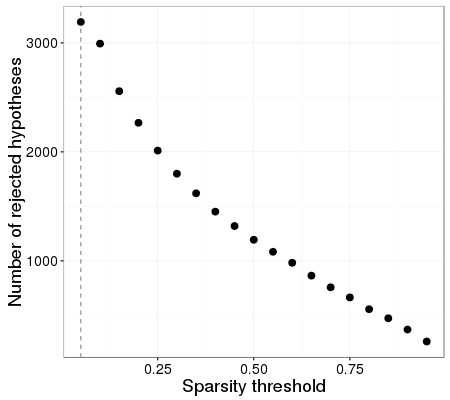

In [18]:
%%R -w 450 -h 400

ggplot(df.l2fc.rejH.s, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(size=3) +
    geom_vline(xintercept=max.rejH, linetype='dashed', alpha=0.5) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        )

In [19]:
%%R
df.l2fc.f = df.l2fc %>%
    filter(sparsity_threshold == 0.25) 

df.l2fc.f %>% nrow

[1] 3964


In [20]:
%%R #-i workDir
# Writing out l2fc table

outFile = 'data/l2fc_Till.txt'
write.table(df.l2fc.f, 'data/l2fc_Till.txt', sep='\t', quote=FALSE, row.names=FALSE)

In [5]:
%%R
df.l2fc = read.table('data/l2fc_Till.txt', sep='\t', header = TRUE)

In [6]:
%%R
df.l2fc$Rank2 = gsub("__", "", df.l2fc$Rank2)
df.l2fc$Rank3 = gsub("__", "", df.l2fc$Rank3)
df.l2fc$Rank4 = gsub("__", "", df.l2fc$Rank4)
df.l2fc$Rank5 = gsub("__", "", df.l2fc$Rank5)
df.l2fc$Rank6 = gsub("__", "", df.l2fc$Rank6)
df.l2fc$Rank7 = gsub("__", "", df.l2fc$Rank7)

In [7]:
%%R
print(length(df.l2fc$OTU))
print(length(unique(df.l2fc$OTU)))

[1] 3964
[1] 3964


In [8]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.10) %>% group_by(Till) %>% summarise(resp = n())
resp %>% as.data.frame

  Till resp
1    N  860
2    T 1152


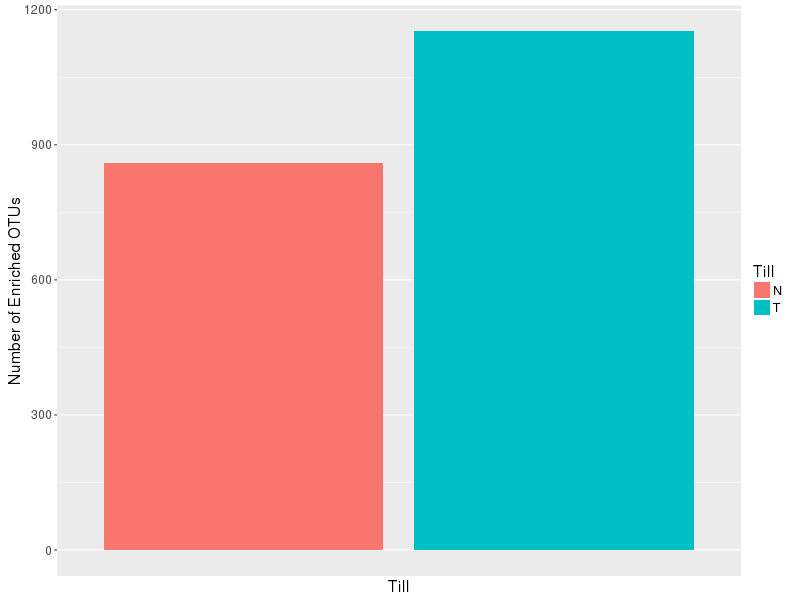

In [9]:
%%R -w 800 -h 600
p = ggplot(data = resp, aes(x = Till, y = resp, fill = Till)) +
    geom_bar(stat = 'identity') + 
    theme(text = element_text(size=16)) + ylab("Number of Enriched OTUs") + scale_x_discrete(breaks=NULL)
p

In [10]:
%%R
ggsave(filename = "data/figs/EnrichedNumoverTime.jpg", plot = p, width =12, height =6)

####Function arguments

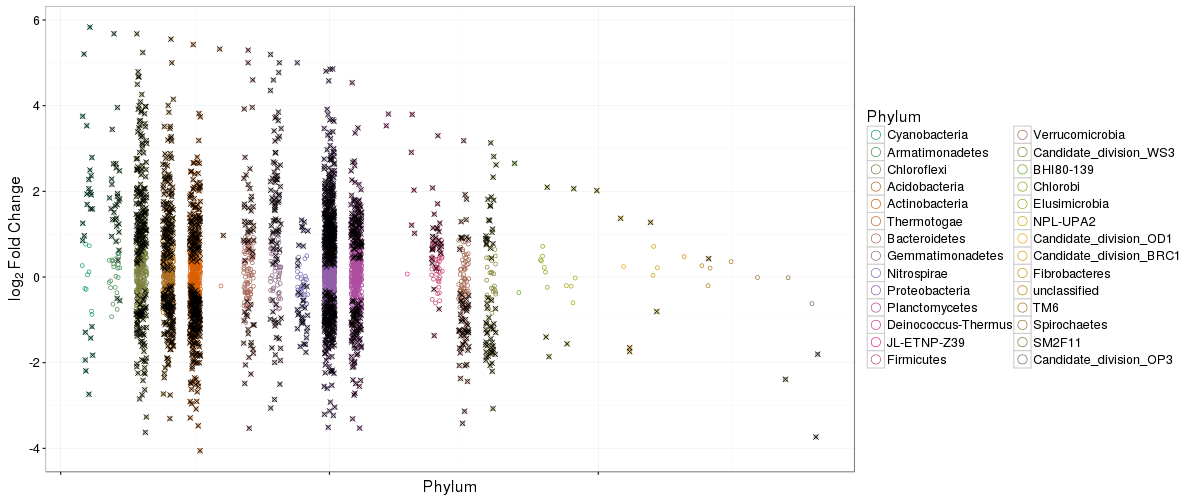

In [11]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj2 <= 0.10), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) #+ guides(color = FALSE)

p

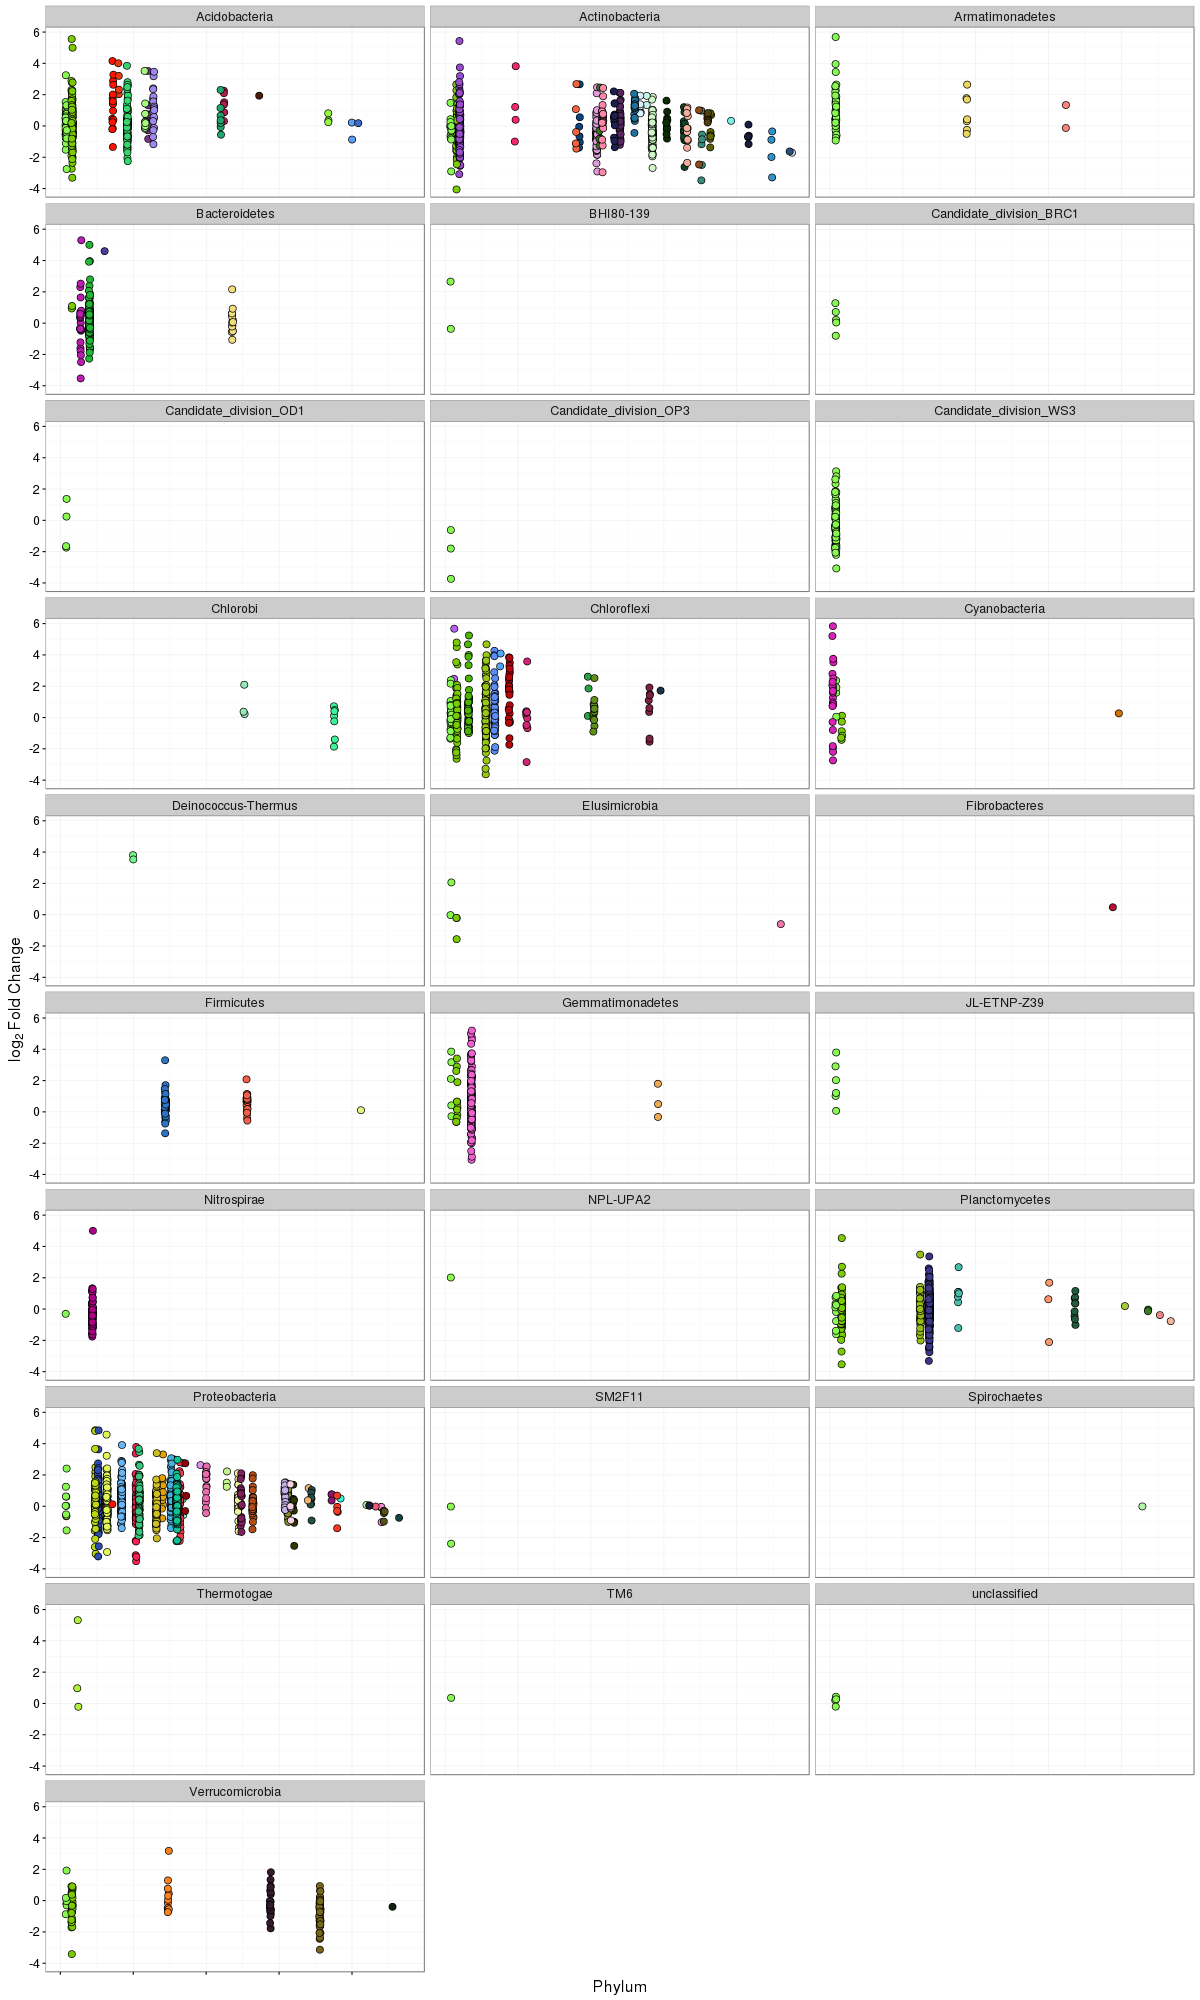

In [14]:
%%R -w 1200 -h 2000
d = df.l2fc
FDR = 0.10

d$Rank4 = as.character(d$Rank4)
d$Rank4[is.na(d$Rank4)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank4)

max.l2fc = ddply(d, .(Rank4), summarize, M = max(log2FoldChange))
d$Rank4 = factor(d$Rank4, max.l2fc[order(-max.l2fc$M),]$Rank4)

M = max(as.numeric(d$Rank4), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank4)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank4))

p = p + geom_point(alpha = 1.00, shape = 21, size = 3)

p = p + scale_fill_manual(values = colors.1)

#p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + guides(fill = FALSE)

p = p + facet_wrap(~Rank2, ncol = 3)

p

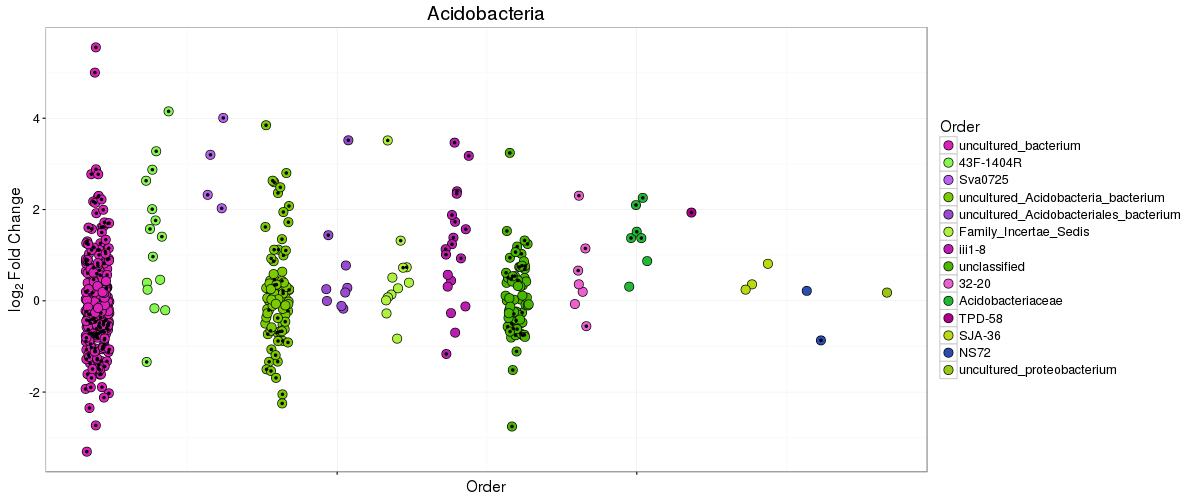

In [15]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

Rank2_filt = 'Acidobacteria'

d = filter(d, Rank2 == Rank2_filt)
d$Rank4 = as.character(d$Rank4)
d$Rank4[is.na(d$Rank4)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank4)

max.l2fc = ddply(d, .(Rank4), summarize, M = max(log2FoldChange))
d$Rank4 = factor(d$Rank4, max.l2fc[order(-max.l2fc$M),]$Rank4)

M = max(as.numeric(d$Rank4), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank4)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank4))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Order", fill = "Order")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle(Rank2_filt)


p

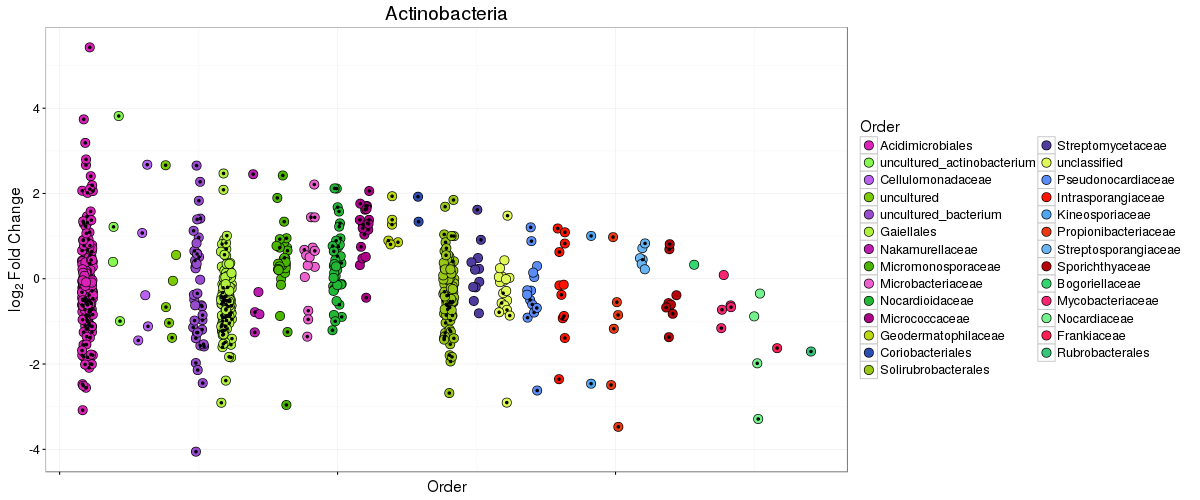

In [16]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

Rank2_filt = 'Actinobacteria'

d = filter(d, Rank2 == Rank2_filt)
d$Rank4 = as.character(d$Rank4)
d$Rank4[is.na(d$Rank4)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank4)

max.l2fc = ddply(d, .(Rank4), summarize, M = max(log2FoldChange))
d$Rank4 = factor(d$Rank4, max.l2fc[order(-max.l2fc$M),]$Rank4)

M = max(as.numeric(d$Rank4), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank4)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank4))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Order", fill = "Order")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle(Rank2_filt)


p

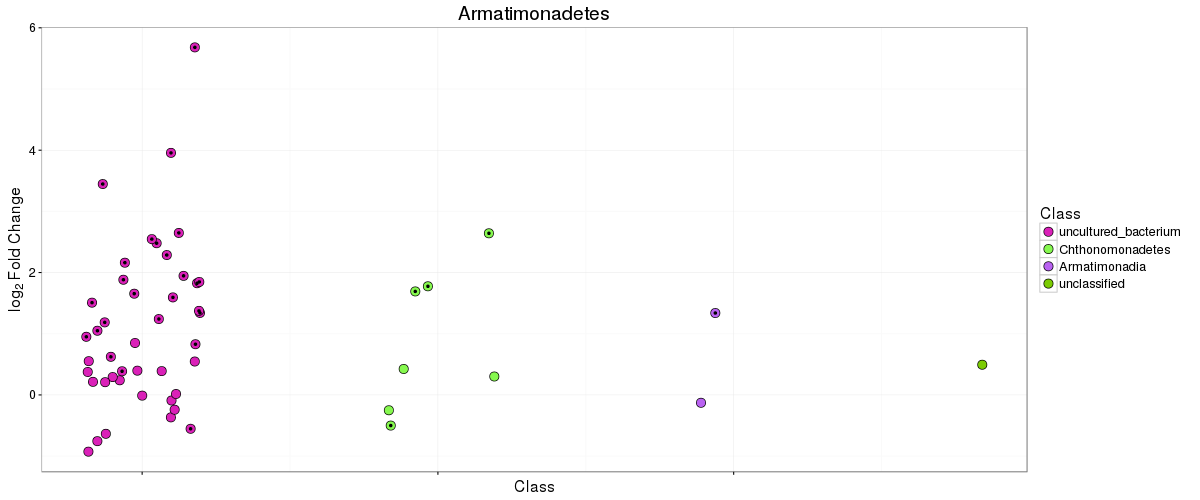

In [17]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

Rank2_filt = 'Armatimonadetes'

d = filter(d, Rank2 == Rank2_filt)
d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank3 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank3))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", fill = "Class")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle(Rank2_filt)


p

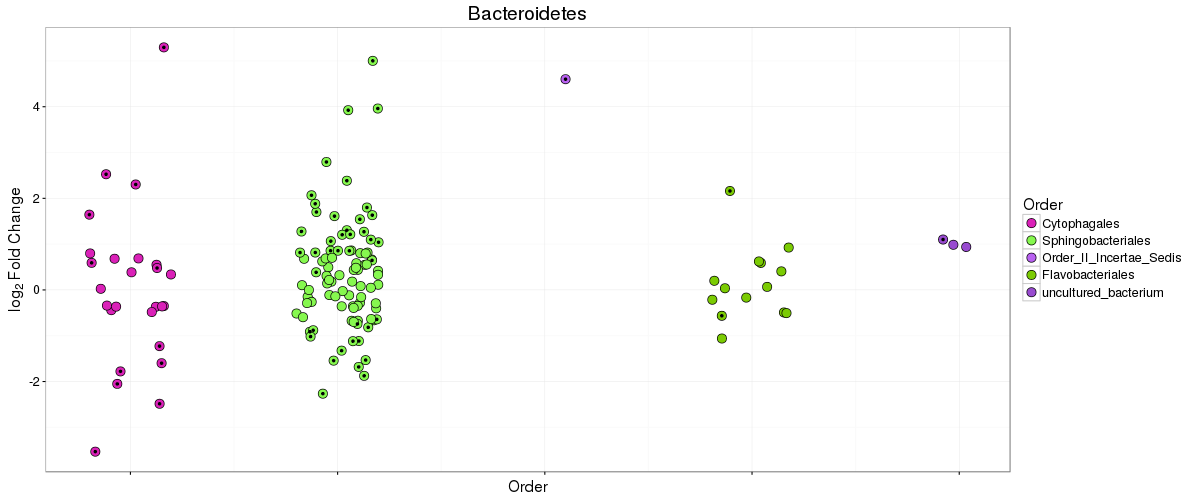

In [18]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

Rank2_filt = 'Bacteroidetes'

d = filter(d, Rank2 == Rank2_filt)
d$Rank4 = as.character(d$Rank4)
d$Rank4[is.na(d$Rank4)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank4)

max.l2fc = ddply(d, .(Rank4), summarize, M = max(log2FoldChange))
d$Rank4 = factor(d$Rank4, max.l2fc[order(-max.l2fc$M),]$Rank4)

M = max(as.numeric(d$Rank4), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank4)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank4))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Order", fill = "Order")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle(Rank2_filt)


p

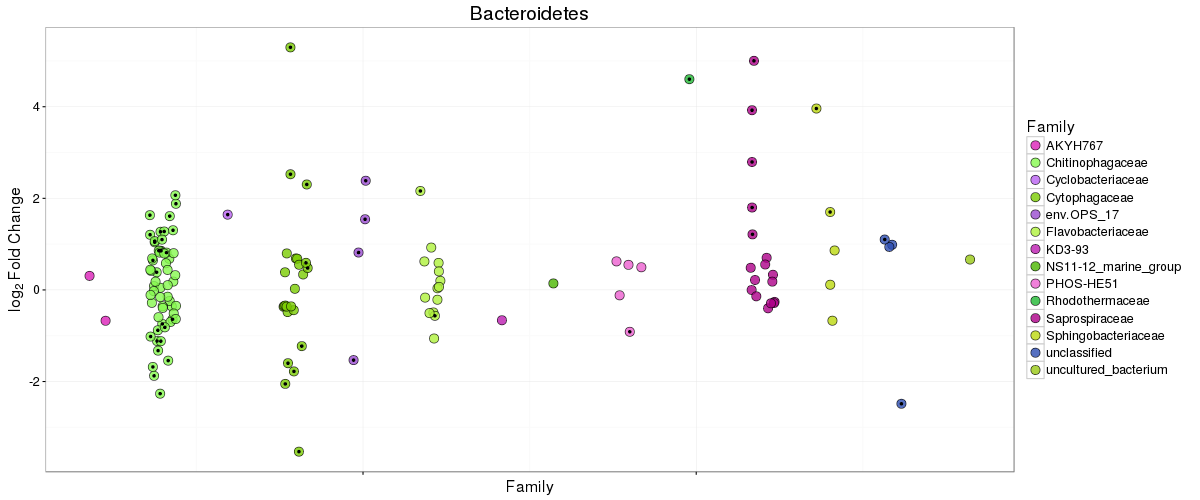

In [19]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

Rank2_filt = 'Bacteroidetes'

d = filter(d, Rank2 == Rank2_filt)
d$Rank5 = as.character(d$Rank5)
d$Rank5[is.na(d$Rank5)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank5= factor(d$Rank5)

max.l2fc = ddply(d, .(Rank5), summarize, M = max(log2FoldChange))
d$Rank4 = factor(d$Rank5, max.l2fc[order(-max.l2fc$M),]$Rank5)

M = max(as.numeric(d$Rank5), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank5)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank5))

p = p + geom_point(alpha = .8, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Family", fill = "Family")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle(Rank2_filt)


p

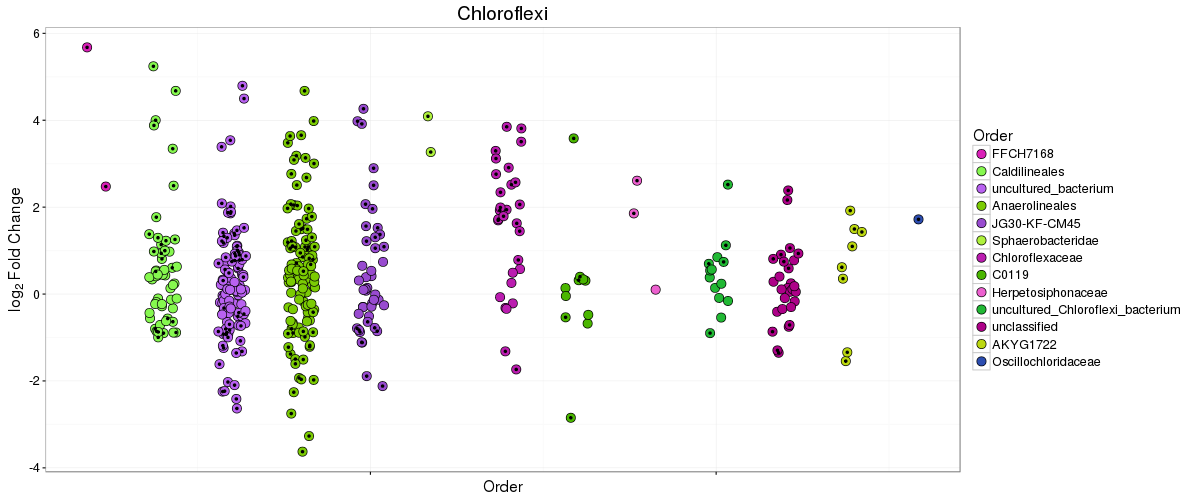

In [20]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

Rank2_filt = 'Chloroflexi'

d = filter(d, Rank2 == Rank2_filt)
d$Rank4 = as.character(d$Rank4)
d$Rank4[is.na(d$Rank4)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank4)

max.l2fc = ddply(d, .(Rank4), summarize, M = max(log2FoldChange))
d$Rank4 = factor(d$Rank4, max.l2fc[order(-max.l2fc$M),]$Rank4)

M = max(as.numeric(d$Rank4), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank4)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank4))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Order", fill = "Order")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle(Rank2_filt)


p

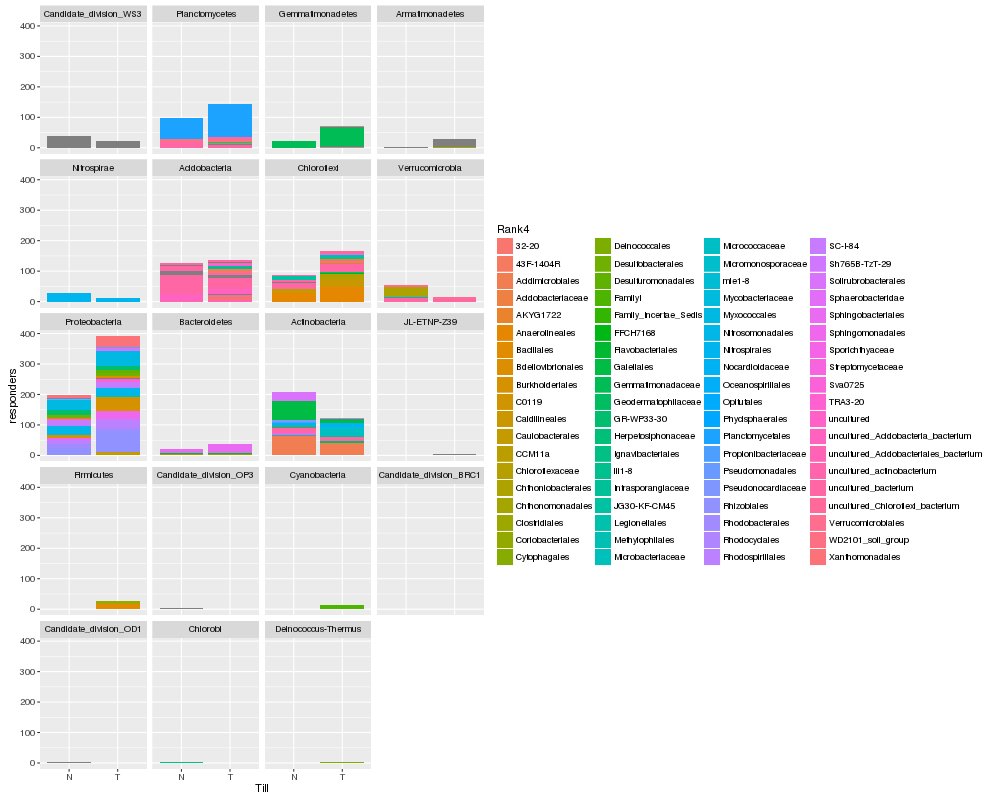

In [21]:
%%R -w 1000 -h 800
dcounts = df.l2fc %>%
          filter(!is.na(log2FoldChange)) %>%
          filter(!is.na(padj)) %>%
          group_by(Rank2, Rank3, Rank4, Rank5, Till) %>%
          summarize(responders = sum(padj<= 0.10))
dcounts = filter(dcounts, responders > 1)
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)


p = ggplot(dcounts, aes(x = Till , y = responders, fill = Rank4)) +
    geom_bar(stat = "identity") +
    facet_wrap( ~ Rank2, ncol = 4, nrow = 7) 

p

In [22]:
%%R
new_df.l2fc = df.l2fc
new_df.l2fc$Resp_status[new_df.l2fc$padj2 > 0.10] = "non-responder"
new_df.l2fc$Resp_status[new_df.l2fc$padj2 <= 0.10 & new_df.l2fc$log2FoldChange < 0] = "NT enriched"
new_df.l2fc$Resp_status[new_df.l2fc$padj2 <= 0.10 &  new_df.l2fc$log2FoldChange > 0] = "PT enriched"

In [23]:
%%R
colors.1 = c("#DA21B8",
"#86F84F",
"#B962F1",
"#7BCB03",
"#984BCF",
"#AFF13D",
"#BB1DB0",
"#4AB600",
"#EC60CF",
"#21B834",
"#AD0188",
"#BCD810",
"#2C4DB0",
"#98C815",
"#503B9E",
"#E1F957",
"#5A8DF8",
"#FD1300",
"#4EA6F4",
"#E93912",
"#68B5F3",
"#B4060B",
"#35D66F",
"#F82573",
"#73F28E",
"#FD1F54",
"#38C67A",
"#D02675",
"#A5F97D",
"#76328B",
"#98BE12",
"#9E88EB",
"#CEBF24",
"#3B3687",
"#E2A205",
"#2C73C3",
"#F7811F",
"#49AFDE",
"#D01C32",
"#0DC593",
"#F23D4F",
"#7DF5CB",
"#8D0506",
"#44C0AC",
"#F3643A",
"#09457F",
"#EDD65D",
"#DA92F0",
"#2AA142",
"#EB6CAD",
"#5F8F1A",
"#DF9ADA",
"#367220",
"#FF87A9",
"#22A470",
"#B12048",
"#C7F38C",
"#1D2151",
"#F0DE7C",
"#57265E",
"#EAF59D",
"#7D225C",
"#96E9B9",
"#F25E47",
"#1C739E",
"#B24E15",
"#DBF2FC",
"#4C1A07",
"#C4F4E7",
"#7C223D",
"#CEF7C5",
"#331B2D",
"#EEAA53",
"#1E3145",
"#FC966D",
"#0B2B05",
"#C4B0E7",
"#898E24",
"#F7D1E8",
"#2D3500",
"#F8847D",
"#114625",
"#F5AD9B",
"#205C39",
"#EDB374",
"#234F4A",
"#8F4918",
"#388C79",
"#796619",
"#513F0C",
"#5C6406",
"#93FB3B",
"#8C166F",
"#3CF397",
"#F63923",
"#2BFBD8",
"#B50F34",
"#7AF0EB",
"#D66E00",
"#579EFB",
"#A4CF32",
"#3E69C7",
"#E4F27B",
"#191D3B",
"#B2F8AB",
"#191D3B",
"#B2F8AB",
"#F15976",
"#38801A",
"#EE8BD6",
"#555415",
"#2F93C9",
"#EF8786",
"#142010",
"#F075AB",
"#0E4442",
"#F1B69C",
"#28507C",
"#CDCDE8")

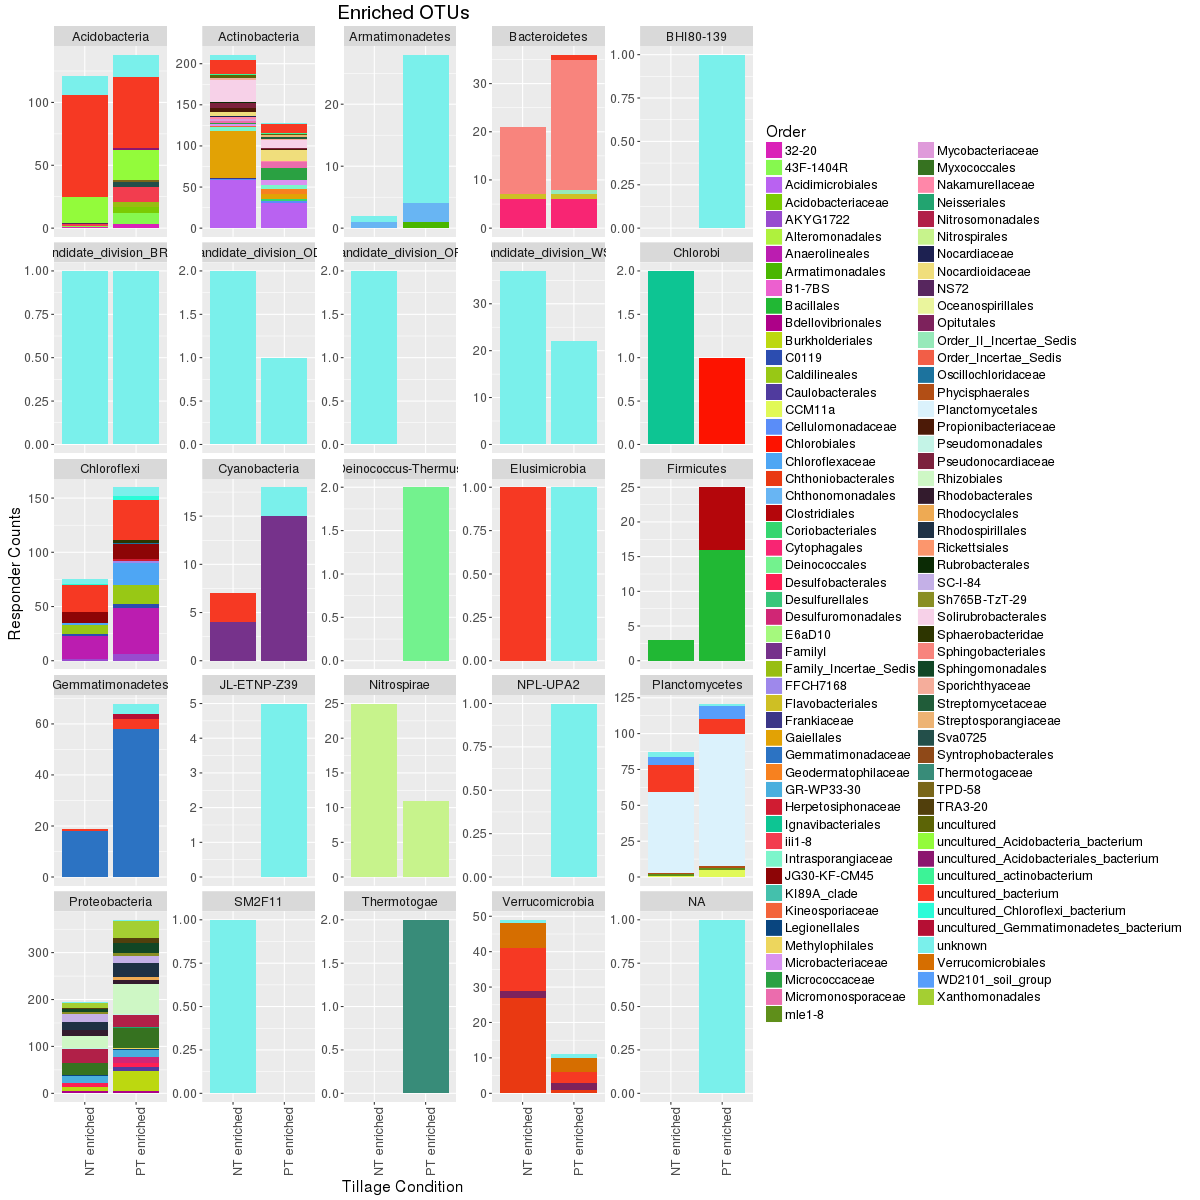

In [24]:
%%R -w 1200 -h 1200
dcounts = new_df.l2fc %>%
          filter(Resp_status %in% c("NT enriched", "PT enriched")) %>%
          group_by(Rank6, Rank5, Rank4, Rank3, Rank2, Resp_status) %>%
          summarize(responders = sum(padj2<= 0.10)) %>% ungroup() %>% arrange(Rank4)

dcounts$Rank4[is.na(dcounts$Rank4)] = "unknown"
dcounts$Rank5[is.na(dcounts$Rank5)] = "unknown"

dcounts$Rank4 = reorder(dcounts$Rank4, dcounts$Rank2)
#dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)

p = ggplot(dcounts, aes(x = Resp_status , y = responders, fill = Rank4)) +
    geom_bar(stat = "identity") + #scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap(~Rank2, scales = "free_y") +
    #scale_y_discrete(limits = (0, 50)) +
    ggtitle("Enriched OTUs") + ylab("Responder Counts")+
    xlab("Tillage Condition") + guides(fill=guide_legend(title='Order', ncol = 2)) +
    theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) +#, legend.position=c(2, 0.2)) +
    scale_fill_manual(values = colors.1)


p

In [25]:
%%R
ggsave(filename = "data/figs/TillEnriched_byOrder.jpg", plot = p, width =20, height =14)

In [26]:
%%R
filter(dcounts, Rank2 == 'Cyanobacteria') %>% as.data.frame

                       Rank6                Rank5                Rank4
1                     Nostoc             Anabaena              FamilyI
2       uncultured_bacterium         Leptolyngbya              FamilyI
3  uncultured_cyanobacterium         Leptolyngbya              FamilyI
4                       <NA>         Leptolyngbya              FamilyI
5                       <NA>          Microcoleus              FamilyI
6                       <NA>               Nostoc              FamilyI
7                       <NA>               Nostoc              FamilyI
8                       <NA>           Phormidium              FamilyI
9                       <NA>           uncultured              FamilyI
10                      <NA> uncultured_bacterium              FamilyI
11                      <NA>              unknown              FamilyI
12                      <NA>              unknown              FamilyI
13                      <NA>              unknown              FamilyI
14    

In [27]:
%%R
length(unique(dcounts$Rank3))

[1] 89


In [28]:
%%R
colors = c("#F076F9",
"#3BF853",
"#8944B9",
"#93FB3B",
"#8C166F",
"#3CF397",
"#F63923",
"#2BFBD8",
"#B50F34",
"#7AF0EB",
"#D66E00",
"#579EFB",
"#A4CF32",
"#3E69C7",
"#E4F27B",
"#191D3B",
"#B2F8AB",
"#F15976",
"#38801A",
"#EE8BD6",
"#555415",
"#2F93C9",
"#EF8786",
"#142010",
"#F075AB",
"#0E4442",
"#F1B69C",
"#28507C",
"#CDCDE8")

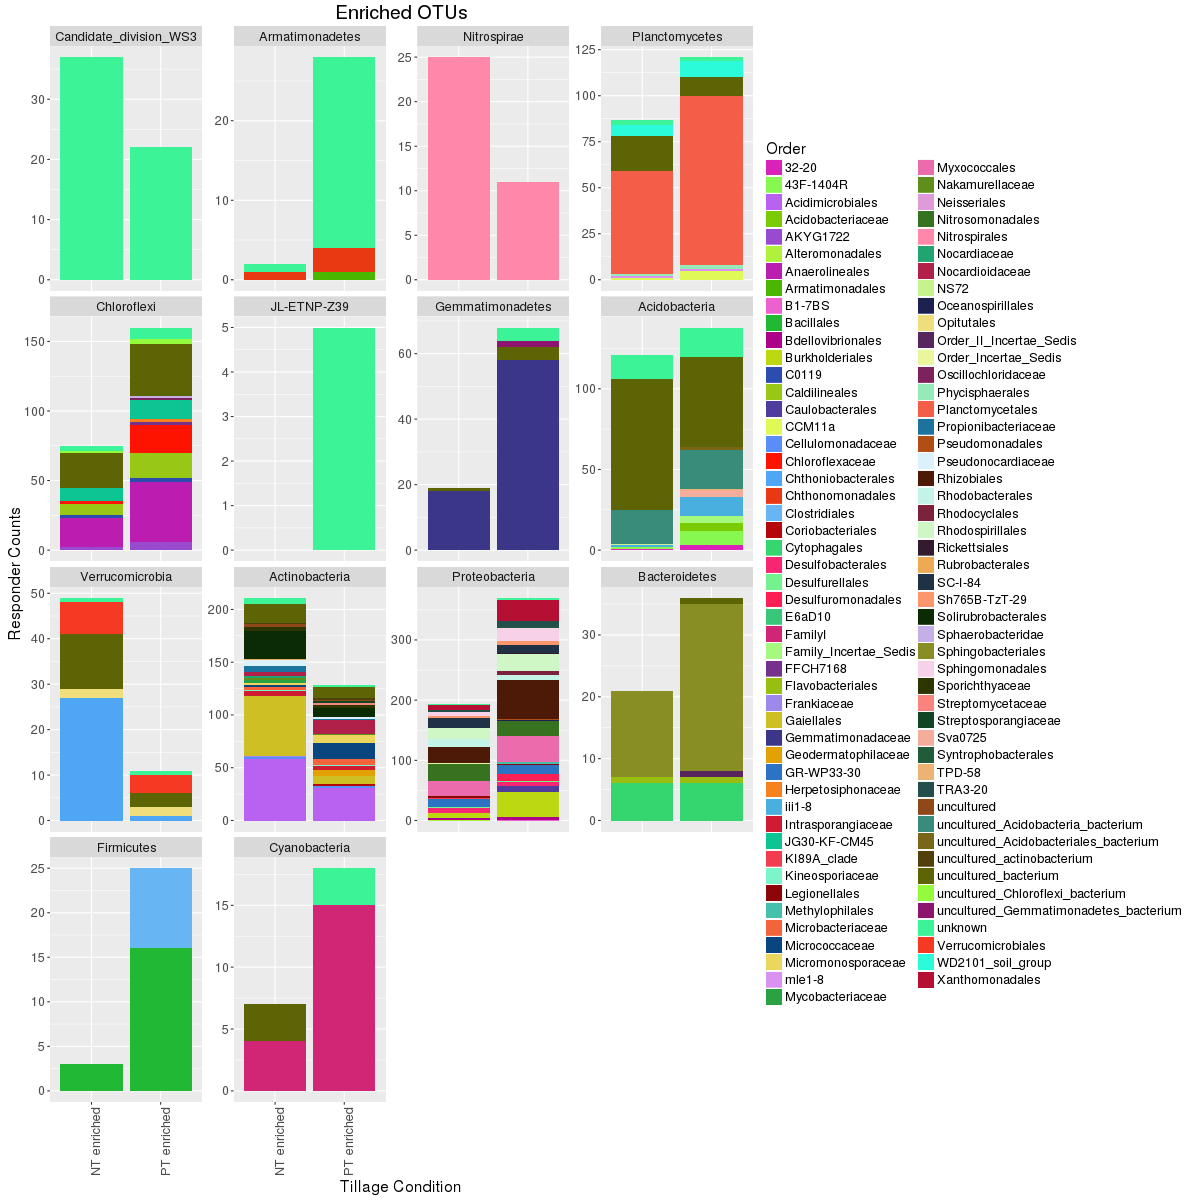

In [39]:
%%R -w 1200 -h 1200
Resp.to.keep = new_df.l2fc %>% group_by(Rank2, Resp_status) %>% summarise(Resp = sum(padj2<= 0.10)) %>% filter(Resp > 2)

dcounts.filt = filter(dcounts, Rank2 %in% Resp.to.keep$Rank2)

dcounts.filt$Rank3 = reorder(dcounts.filt$Rank3, -dcounts.filt$responders)
dcounts.filt$Rank2 = reorder(dcounts.filt$Rank2, -dcounts.filt$responders)


p = ggplot(dcounts.filt, aes(x = Resp_status , y = responders, fill = Rank4)) +
    geom_bar(stat = "identity") + #scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap(~Rank2, scales = "free_y") +
    #scale_y_discrete(limits = (0, 50)) +
    ggtitle("Enriched OTUs") + ylab("Responder Counts")+
   xlab("Tillage Condition") + guides(fill=guide_legend(title='Order', ncol = 2)) +
    theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) +#, legend.position=c(2, 0.2)) +
    scale_fill_manual(values = colors.1)



p

In [40]:
%%R
ggsave(filename = "data/figs/TillEnriched_byOrder_filt.jpg", plot = p, width =12, height =14)

In [31]:
%%R
length(unique(d.counts.filt$Rank3))


Error in unique(d.counts.filt$Rank3) : object 'd.counts.filt' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in unique(d.counts.filt$Rank3) : object 'd.counts.filt' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: There were 50 or more warnings (use warnings() to see the first 50)
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [32]:
%%R
head(df.l2fc)

  sparsity_threshold       OTU log2FoldChange     lfcSE         padj    Rank1
1               0.25  OTU.1739      0.4012126 0.4523957 4.684148e-01 Bacteria
2               0.25  OTU.1813     -1.4802581 0.4326507 1.826795e-03 Bacteria
3               0.25   OTU.778     -0.5498601 0.1379296 2.483877e-04 Bacteria
4               0.25  OTU.2180     -0.3066501 0.2858391 3.755368e-01 Bacteria
5               0.25 OTU.12365     -0.1443963 0.2567288 6.562578e-01 Bacteria
6               0.25  OTU.2343      1.3595096 0.3116793 5.598476e-05 Bacteria
           Rank2        Rank3                Rank4 Rank5 Rank6 Rank7 Rank8
1 Planctomycetes        OM190 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>
2 Planctomycetes        OM190 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>
3 Planctomycetes Pla4_lineage uncultured_bacterium  <NA>  <NA>  <NA>  <NA>
4 Planctomycetes Pla4_lineage uncultured_bacterium  <NA>  <NA>  <NA>  <NA>
5 Planctomycetes Pla4_lineage uncultured_bacterium  <NA>  <NA>  <NA>  <NA>
6 Pl

In [33]:
%%R
new_df.l2fc = df.l2fc
new_df.l2fc$Resp_status[new_df.l2fc$padj2 <=0.10 & new_df.l2fc$log2FoldChange > 0] = 'T Enriched'
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 & new_df.l2fc$log2FoldChange < 0] = 'NT Enriched'
new_df.l2fc$Resp_status[new_df.l2fc$padj > 0.10] = 'Not Enriched'



head(new_df.l2fc)

  sparsity_threshold       OTU log2FoldChange     lfcSE         padj    Rank1
1               0.25  OTU.1739      0.4012126 0.4523957 4.684148e-01 Bacteria
2               0.25  OTU.1813     -1.4802581 0.4326507 1.826795e-03 Bacteria
3               0.25   OTU.778     -0.5498601 0.1379296 2.483877e-04 Bacteria
4               0.25  OTU.2180     -0.3066501 0.2858391 3.755368e-01 Bacteria
5               0.25 OTU.12365     -0.1443963 0.2567288 6.562578e-01 Bacteria
6               0.25  OTU.2343      1.3595096 0.3116793 5.598476e-05 Bacteria
           Rank2        Rank3                Rank4 Rank5 Rank6 Rank7 Rank8
1 Planctomycetes        OM190 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>
2 Planctomycetes        OM190 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>
3 Planctomycetes Pla4_lineage uncultured_bacterium  <NA>  <NA>  <NA>  <NA>
4 Planctomycetes Pla4_lineage uncultured_bacterium  <NA>  <NA>  <NA>  <NA>
5 Planctomycetes Pla4_lineage uncultured_bacterium  <NA>  <NA>  <NA>  <NA>
6 Pl

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

  res = super(Function, self).__call__(*new_args, **new_kwargs)


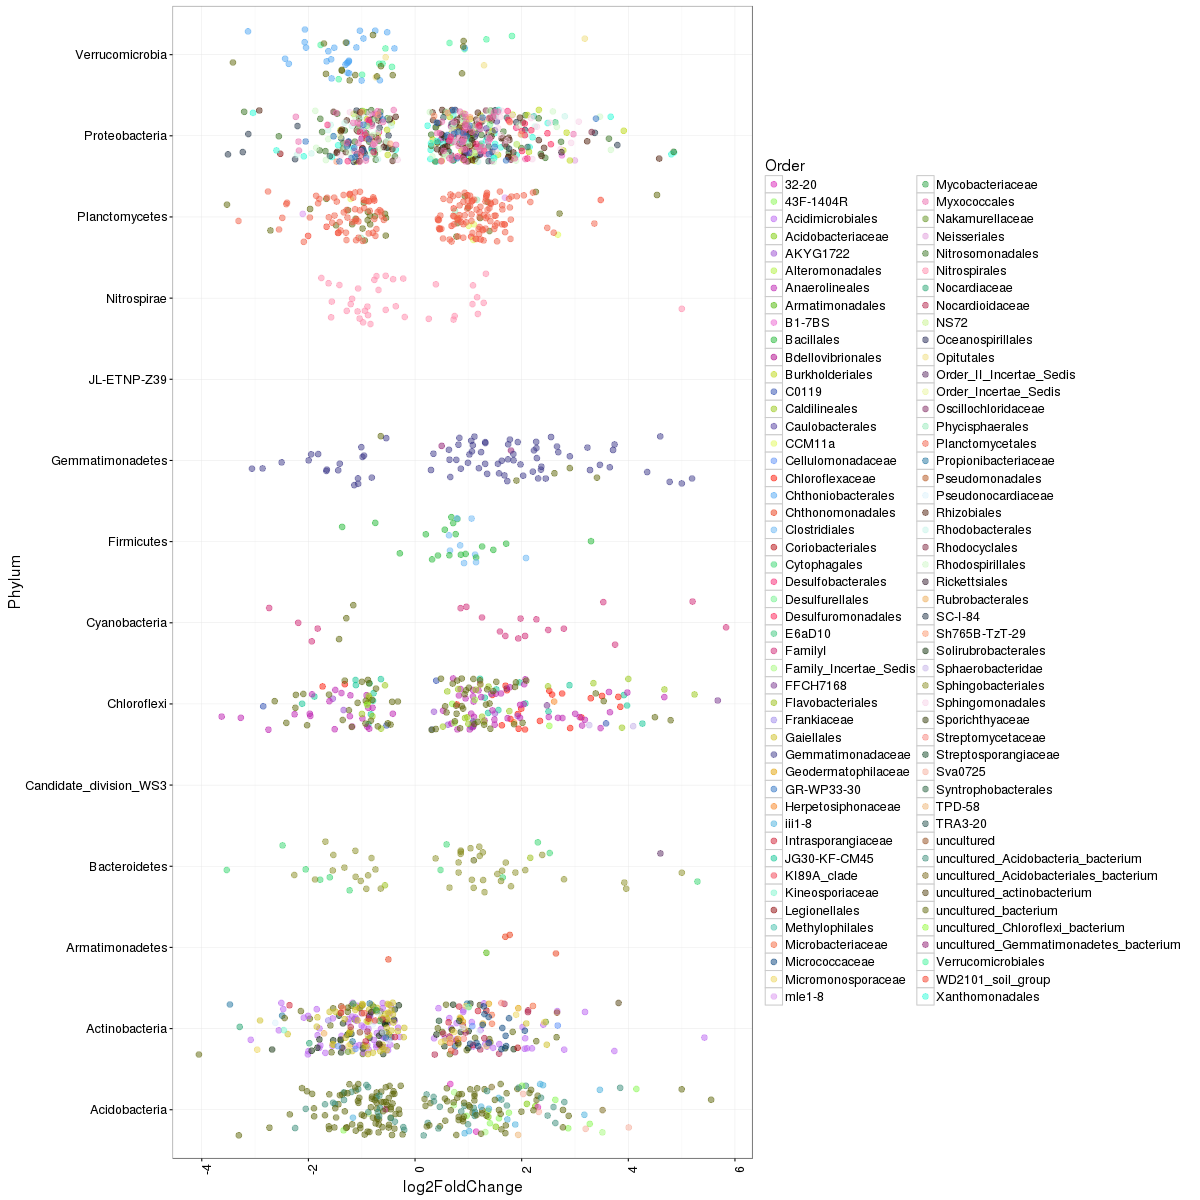

In [34]:
%%R -w 1200 -h 1200
d = filter(new_df.l2fc, padj2 <=0.10)#, 'Relative Abundance' > 0)
d = filter(d, Rank2 %in% dcounts.filt$Rank2)

p = ggplot(d, aes(log2FoldChange, Rank2))
p = p + geom_jitter(aes(color = Rank4), size = 2.5, height = 0.8, alpha = 0.5)
#p = p + facet_wrap(~Rank2, scales = 'free_y')
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
p = p + scale_colour_discrete((name="Responder Status"))
p = p + ylab("Phylum") + theme_bw()

p = p + guides(color=guide_legend(title='Order', ncol = 2)) +
    theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) +#, legend.position=c(2, 0.2)) +
    scale_color_manual(values = colors.1) 
p

In [35]:
%%R
ggsave(plot = p, filename = 'data/figs/l2fc_phylum_class.jpg', height = 14, width = 20)

In [36]:
%%R -w 600 -h 2000


phyla = unique((d.counts.filt$Rank2))

d = filter(new_df.l2fc, padj2 <=0.10)#, 'Relative Abundance' > 0)

plot = function(r, d) {
    plot.d = d %>% filter(Rank2 == r)
    #colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$intense)

   p = ggplot(plot.d, aes(as.numeric(log2FoldChange), Rank3))
    p = p + geom_point(aes(color = Resp_status))
    p = p + scale_colour_discrete((name="Responder Status"))
    p = p + ylab("Class")
    p = p + theme_bw()
    p = p + xlim(-4, 6)
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9), axis.text.y  = element_text(angle=60, vjust=0.5, size=8)) 

        p = p + ggtitle(r)


    p}
    
plots.13CCPS = lapply(phyla, plot, d = d)

do.call(grid.arrange, c(plots.13CCPS,list(ncol=1)))


Error in unique((d.counts.filt$Rank2)) : object 'd.counts.filt' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in unique((d.counts.filt$Rank2)) : object 'd.counts.filt' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [37]:
%%R -w 600 -h 2000


phyla = unique((d.counts.filt$Rank2))

d = filter(new_df.l2fc, padj2 <=0.10)#, 'Relative Abundance' > 0)

plot = function(r, d) {
    plot.d = d %>% filter(Rank2 == r)
    #colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$intense)

   p = ggplot(plot.d, aes(as.numeric(log2FoldChange), Rank3, fill = Rank4))
    p = p + geom_point()
    p = p + scale_colour_discrete((name="Responder Status"))
    p = p + ylab("Class")
    p = p + theme_bw()
    p = p + xlim(-4, 6)
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9), axis.text.x  = element_text(angle=90, vjust=0.5, size=10)) 

        p = p + ggtitle(r)


    p}
    
plots.13CCPS = lapply(phyla, plot, d = d)

do.call(grid.arrange, c(plots.13CCPS,list(ncol=1)))


Error in unique((d.counts.filt$Rank2)) : object 'd.counts.filt' not found
